In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import pandas_datareader as pdr

In [82]:
start='2010-01-01'
end= date.isoformat(date.today())


In [83]:
dataset=pdr.DataReader('AAPL','yahoo',start,end)

In [84]:
dataset=dataset.reset_index()

In [85]:
dataset=dataset.drop(['Date','Adj Close'],axis=1)

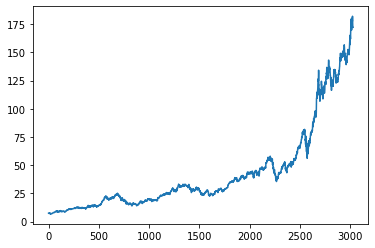

In [86]:
plt.plot(dataset.Close)

In [87]:
#moving avg 100
mv100=dataset.Close.rolling(100).mean()
mv200=dataset.Close.rolling(200).mean()

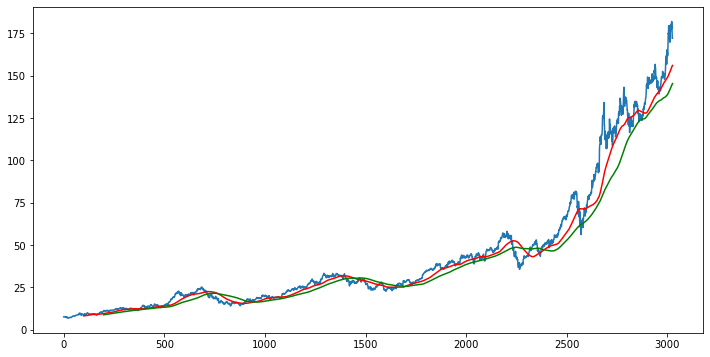

In [88]:
#plotting the moving average 100
plt.figure(figsize=(12,6))
plt.plot(dataset.Close)
plt.plot(mv100,'r')
plt.plot(mv200,'g')

In [89]:
dataset.shape

(3027, 5)

In [90]:
training_set= pd.DataFrame(dataset["Close"][0:int(len(dataset)*.70)])
testing_set= pd.DataFrame(dataset["Close"][int(len(dataset)*.70): int(len(dataset))])

In [91]:
training_set.shape

(2118, 1)

In [92]:
#remember that for LSTM model we have to ensure that the data is scaled between 0&1
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
dt_train_sc=sc.fit_transform(training_set)

In [93]:
x_train=[]
y_train=[]
for i in range(100,dt_train_sc.shape[0]):
    x_train.append(dt_train_sc[i-100:i])
    y_train.append(dt_train_sc[i,0])
x_train,y_train=np.array(x_train),np.array(y_train)
x_train.shape

(2018, 100, 1)

In [94]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [58]:
#defining the model
regressor=Sequential()
regressor.add(LSTM(units=50,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))
#units refer to as to how many such units have to be made more or like 3rd dimension
regressor.add(LSTM(units=60,activation='relu',return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80,activation='relu',return_sequences=True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units=120,activation='relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

In [95]:
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_5 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_6 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_8 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_7 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_9 (LSTM)               (None, 120)              

In [64]:
regressor.compile(optimizer='adam',loss='mean_squared_error') #adam is the optimizer generally used for big data
#loss gives more or less the acuuray of the model or the loss of data in each cycle of training
#training the model
regressor.fit(x_train,y_train,epochs=60,batch_size=32)

Epoch 1/60
64/64 [==============================] - 10s 118ms/step - loss: 0.0465
Epoch 2/60
64/64 [==============================] - 7s 113ms/step - loss: 0.0079
Epoch 3/60
64/64 [==============================] - 10s 155ms/step - loss: 0.0071
Epoch 4/60
64/64 [==============================] - 11s 174ms/step - loss: 0.0066
Epoch 5/60
64/64 [==============================] - 11s 172ms/step - loss: 0.0054
Epoch 6/60
64/64 [==============================] - 11s 175ms/step - loss: 0.0060
Epoch 7/60
64/64 [==============================] - 11s 164ms/step - loss: 0.0058
Epoch 8/60
64/64 [==============================] - 11s 169ms/step - loss: 0.0052
Epoch 9/60
64/64 [==============================] - 11s 168ms/step - loss: 0.0048
Epoch 10/60
64/64 [==============================] - 11s 164ms/step - loss: 0.0046
Epoch 11/60
64/64 [==============================] - 11s 171ms/step - loss: 0.0046
Epoch 12/60
64/64 [==============================] - 12s 180ms/step - loss: 0.0042
Epoch 13/60
64

In [80]:
sc_test=MinMaxScaler(feature_range=(0,1))
prev_data=training_set.tail(100)
f_test=prev_data.append(testing_set,ignore_index=True)
f_test_sc=sc_test.fit_transform(f_test)

In [96]:
x_test=[]
y_test=[]
for i in range(100,f_test_sc.shape[0]):
    x_test.append(f_test_sc[i-100:i])
    y_test.append(f_test_sc[i])
x_test,y_test=np.array(x_test),np.array(y_test)


In [97]:
#predicting the data

y_predicted= regressor.predict(x_test)

In [98]:
y_test=sc_test.inverse_transform(y_test)
y_predicted=sc_test.inverse_transform(y_predicted)


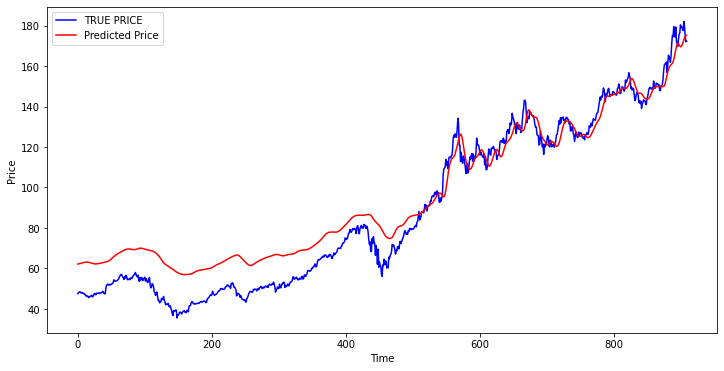

In [100]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b',label="TRUE PRICE")
plt.plot(y_predicted,'r',label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [102]:
regressor.save('stock_model.h5')